In [1]:
import cv2
import numpy as np

# 加载YOLOv3或YOLOv4
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
# 获取输出层
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
# 加载类别名称
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# 设置颜色
colors = np.random.uniform(0, 255, size=(len(classes), 3))


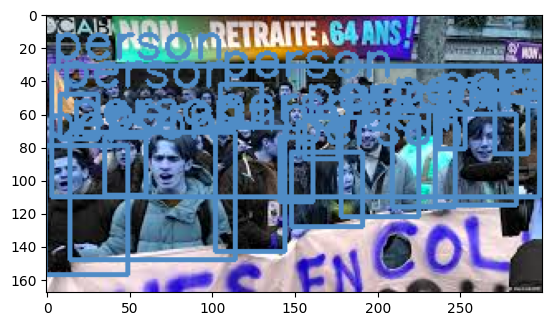

In [11]:
import matplotlib.pyplot as plt
frame = cv2.imread(r'aaa.jpg')
if True:
    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(
        frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    # 获取检测结果
    net.setInput(blob)
    outs = net.forward(output_layers)

    # 处理检测结果
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # 目标的坐标信息是相对于图像宽度和高度的比例，需要转换为像素坐标
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # 非最大抑制（去除重叠的边界框，使用置信度作为分数进行排序）
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label, (x, y - 5), font, 1, color, 2)

    # 显示结果
    cv2.imshow("Image", frame)
    plt.imshow(frame)


In [ ]:
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if ret:
        # 调整图像大小
        height, width, channels = frame.shape
        blob = cv2.dnn.blobFromImage(
            frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        # 获取检测结果
        net.setInput(blob)
        outs = net.forward(output_layers)

        # 处理检测结果
        class_ids = []
        confidences = []
        boxes = []
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    # 目标的坐标信息是相对于图像宽度和高度的比例，需要转换为像素坐标
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        # 非最大抑制（去除重叠的边界框，使用置信度作为分数进行排序）
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        font = cv2.FONT_HERSHEY_SIMPLEX
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                color = colors[class_ids[i]]
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                cv2.putText(frame, label, (x, y - 5), font, 1, color, 2)

        # 显示结果
        cv2.imshow("Image", frame)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()